In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

Populating the interactive namespace from numpy and matplotlib


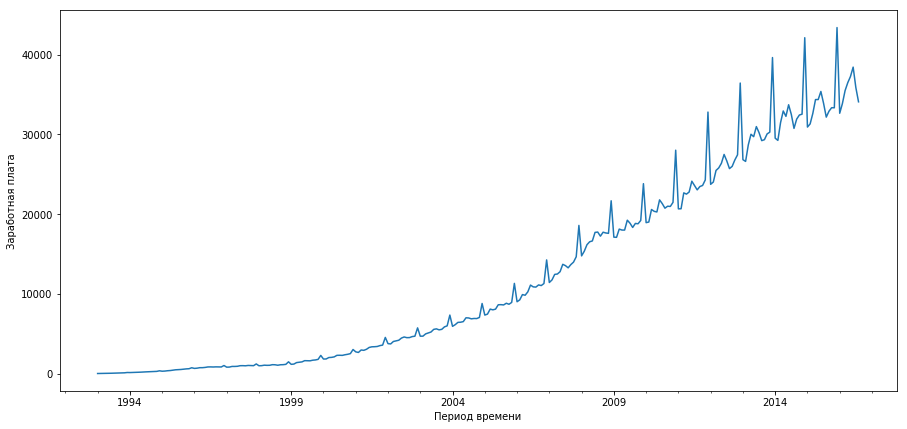

In [2]:
df = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

plt.figure(figsize(15,7))
df.WAG_C_M.plot()
plt.ylabel(u'Заработная плата')
plt.xlabel(u'Период времени')
pylab.show()

Проверка стационарности выполняетс по критерию Дики-Фуллера, с проверкой гипотезы  
$H_0\colon$ ряд нестационарен  
и выполнение STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

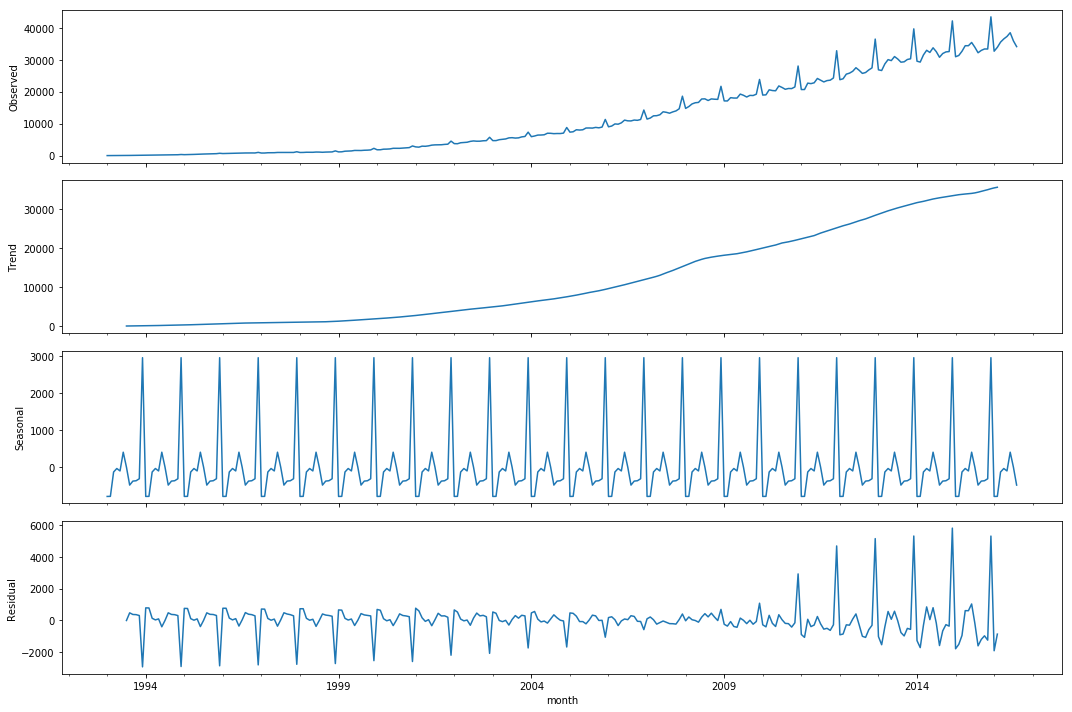

In [3]:
plt.figure(figsize(15,10))
seasonal_decompose_rez = sm.tsa.seasonal_decompose(df.WAG_C_M)
seasonal_decompose_rez.plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])
plt.show()

Критерий Дики-Фуллера p=0.991850 не позволяет отклонить гипотезу $H_0\colon$ ряд нестационарен на уровне 0.05.  
Кроме того, о нестационарности ряда говорит четко выраженный тренд и наличие в ряде монотонно по времени изменяющейся дисперсии.


Применяем преобразование, преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


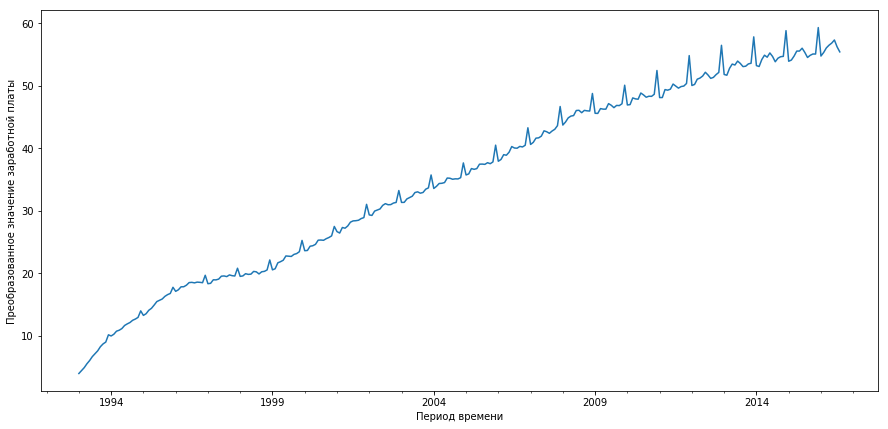

In [4]:
df['boxcox'], lmbda = stats.boxcox(df.WAG_C_M)
plt.figure(figsize(15,7))
df.boxcox.plot()
plt.ylabel(u'Преобразованное значение заработной платы')
plt.xlabel(u'Период времени')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.boxcox)[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд.  
По рекомендациям лекций сначала проводим сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

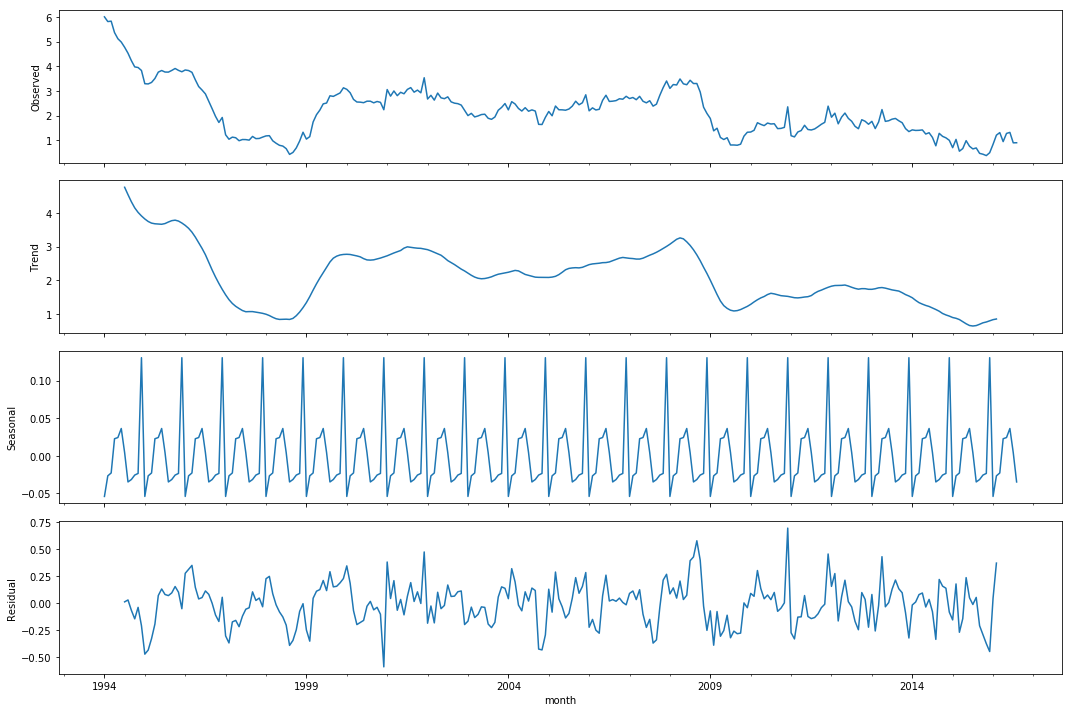

In [5]:
df['boxcox_diff'] = df.boxcox - df.boxcox.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.boxcox_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.boxcox_diff[12:])[1])

Критерий Дики-Фуллера (p=0.014697) отвергает гипотезу нестационарности на уровне 0.05, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=5.203604e-08


<Figure size 1080x720 with 0 Axes>

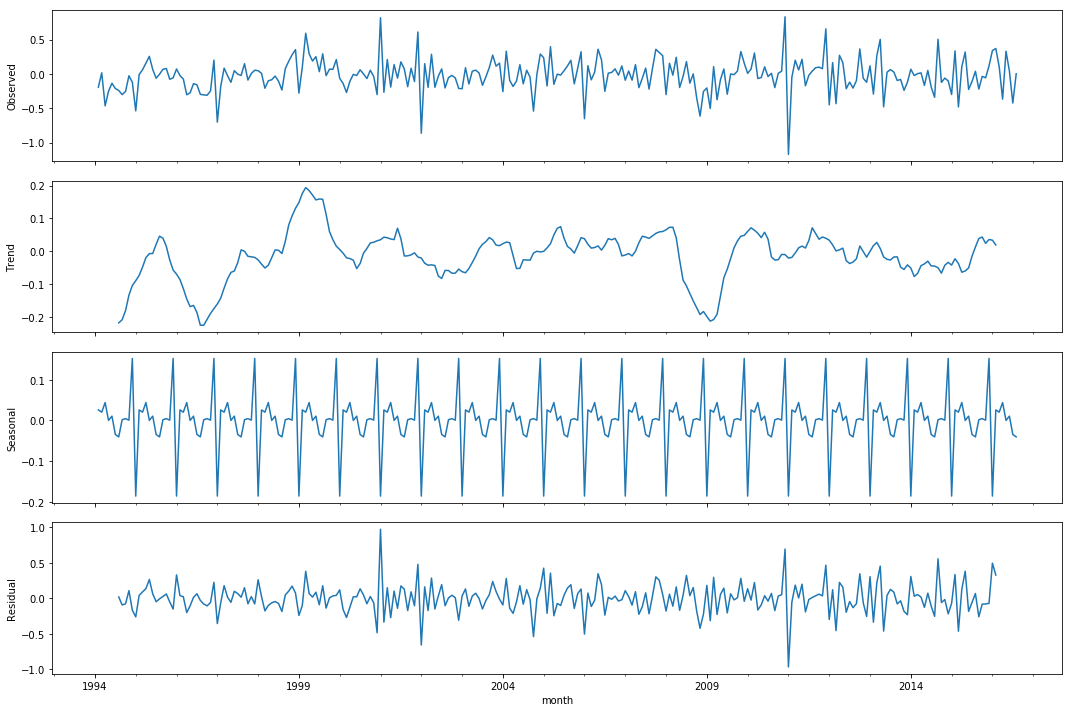

In [6]:
df['boxcox_diff2'] = df.boxcox_diff - df.boxcox_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.boxcox_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(df.boxcox_diff2[13:])[1])

Гипотеза нестационарности отвергается на уровне 0.05 (p=5.203604e-08), и визуально ряд выглядит лучше — тренда больше нет.

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

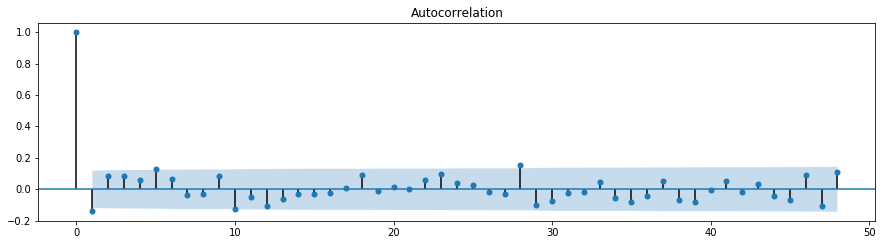

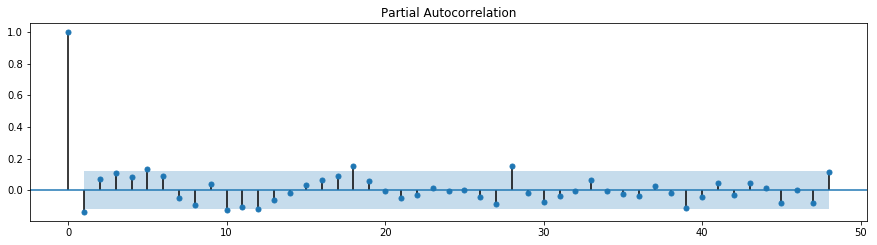

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=10, P=1, p=10

In [8]:
ps = range(0, 11)
d=1
qs = range(0, 11)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

242

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 10, 0, 0))
('wrong parameters:', (1, 10, 1, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 3, 0, 0))
('wrong parameters:', (2, 3, 1, 0))
('wrong parameters:', (2, 10, 0, 0))
('wrong parameters:', (2, 10, 1, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 3, 0, 0))
('wrong parameters:', (3, 3, 1, 0))
('wrong parameters:', (3, 4, 0, 0))
('wrong parameters:', (3, 4, 1, 0))
('wrong parameters:', (3, 10, 0, 0))
('wrong parameters:', (3, 10, 1, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 3, 0, 0))
('wrong parameters:', (4, 3, 1, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', 

In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
86   (5, 5, 1, 0) -25.841081
102  (6, 5, 1, 0) -24.050056
85   (5, 5, 0, 0) -22.643734
104  (6, 6, 1, 0) -21.128929
62   (3, 7, 1, 0) -20.884665


Лучшая модель:

In [18]:
best_model.aic

In [12]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             boxcox   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.921
Date:                            Sat, 11 May 2019   AIC                            -25.841
Time:                                    22:13:50   BIC                             17.947
Sample:                                01-01-1993   HQIC                            -8.286
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0220     11.282      0.002      0.998     -22.090      22.134
ar.L2          0.0259      7.537   

Её остатки:

Критерий Стьюдента: p=0.182315
Критерий Дики-Фуллера: p=4.247060e-29


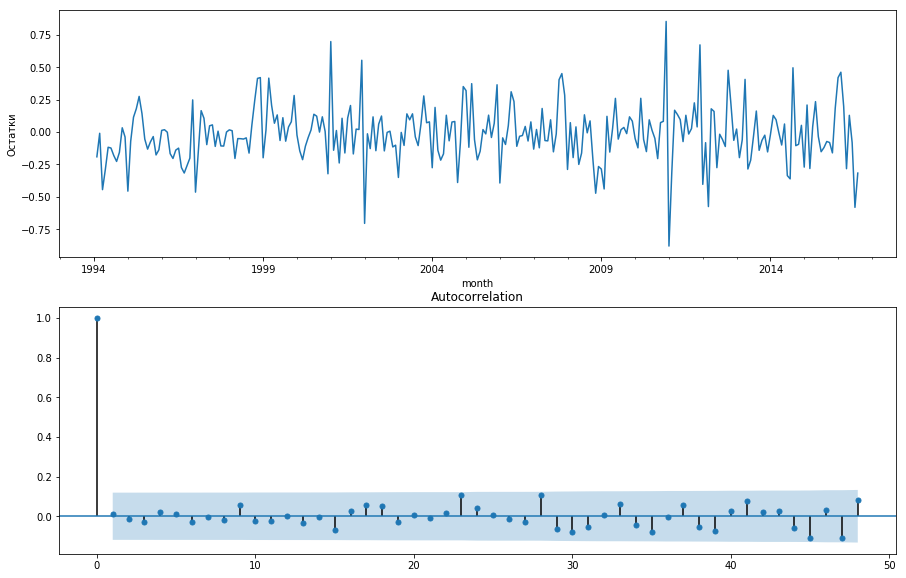

In [13]:
plt.figure(figsize(15, 10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Остатки')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Гипотезу о неавтокоррелированности проверяется с помощью Q-критерия Льюнга-Бокса.  
Гипотеза $H_0\colon$ отсчёты временного ряда статистически независимы,

In [14]:
q_test = sm.tsa.stattools.acf(best_model.resid[13:].values.squeeze(), qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})

       Q-stat   p-value
0    0.023107  0.879178
1    0.094815  0.953698
2    0.301976  0.959656
3    0.450990  0.978093
4    0.475684  0.992987
5    0.687731  0.994752
6    0.696315  0.998364
7    0.783641  0.999281
8    1.770545  0.994598
9    1.951711  0.996697
10   2.101239  0.998107
11   2.101240  0.999234
12   2.483934  0.999247
13   2.487537  0.999689
14   3.788454  0.998352
15   3.959240  0.998972
16   4.937501  0.997942
17   5.769151  0.997046
18   6.043864  0.997822
19   6.056392  0.998819
20   6.073969  0.999369
21   6.143788  0.999644
22   9.524818  0.993852
23  10.042564  0.994369
24  10.049514  0.996517
25  10.098074  0.997807
26  10.371574  0.998344
27  13.912396  0.987799
28  15.205251  0.983349
29  17.024440  0.972280
30  17.898809  0.970827
31  17.912573  0.978801
32  19.120899  0.974215
33  19.720771  0.975863
34  21.764407  0.960718
35  21.770709  0.970446
36  22.739581  0.968307
37  23.671405  0.966611
38  25.524795  0.952591
39  25.774852  0.960311


Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается Q-критерием Льюнга-Бокса (на уровне 0.05 гипотеза $H_0\$ не отвергается) и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

In [15]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

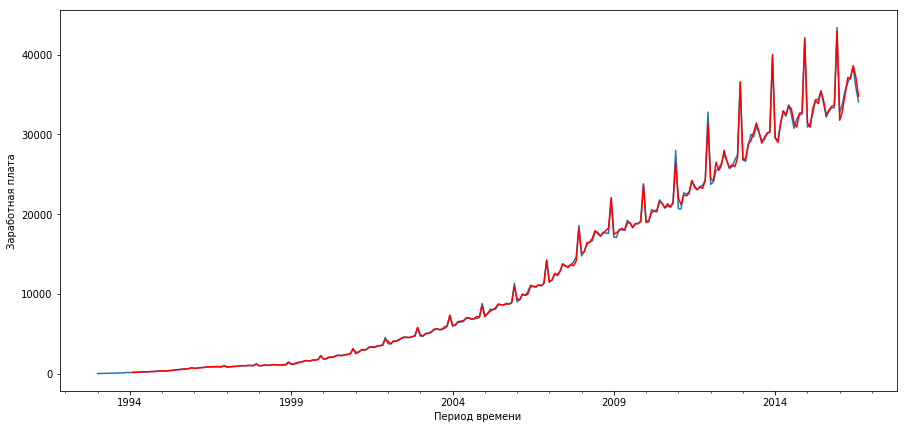

In [16]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.ylabel(u'Заработная плата')
plt.xlabel(u'Период времени')
pylab.show()

### Прогноз

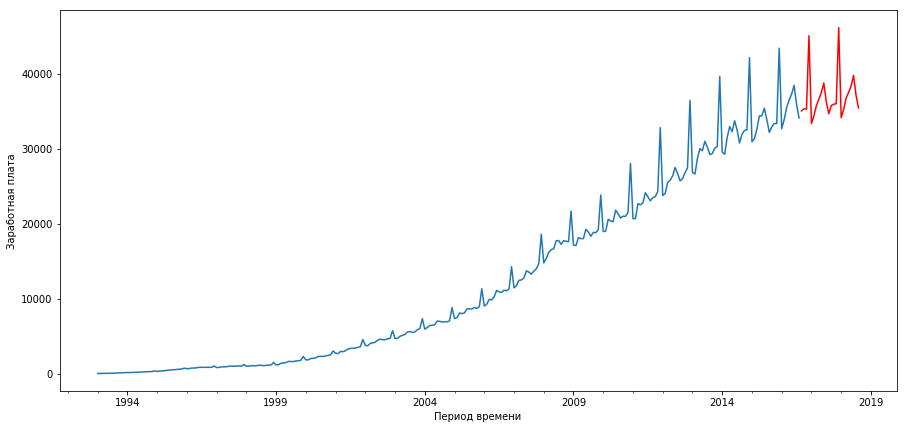

In [17]:
df2 = df[['WAG_C_M']]
date_list = [max(df2.index) + relativedelta(months=x) for x in range(1,25)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=df.shape[0], end=df2.shape[0]), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel(u'Заработная плата')
plt.xlabel(u'Период времени')
pylab.show()